# Predict ligand profiling using `kissim` - detailed inspection

## Aim of this notebook

Let's take a closer look at an example kinase-ligand pair. 

- What are measured on- and off-targets?
- How does bioactivity data correlate with `kissim` ranks?
- Is the kinase an easy target (a) because underlying structures are co-crystallized with the same ligands or (b) because detected off-targets are very close (kinase group, family)? 
- Is the kinase a difficult target (a) because the tested ligand is a type II ligand although most structures bind type I ligands or (b) because we only have a low structural coverage for the kinase?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from opencadd.databases import klifs
from kissim.comparison import FingerprintDistanceGenerator

from src import data, evaluation

In [3]:
plt.style.use("seaborn")

In [4]:
klifs_session = klifs.setup_remote()

## Define parameters

In [5]:
# The only global that can be changed in this notebook
LIGAND_PROFILING_METHOD = "karaman"

In [6]:
KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

In [7]:
LIGAND_EXAMPLE = "Erlotinib"
KINASE_EXAMPLE = "EGFR"

## Load data

### Generate evaluation data

In [8]:
evaluator = evaluation.LigandVsKinaseEvaluator(
    [[LIGAND_EXAMPLE, KINASE_EXAMPLE]],
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    MIN_N_SHARED_KINASES,
    MIN_N_SHARED_ACTIVE_KINASES,
)

Changed ligand names (unknown names may be discarded - see function docstring):
           ligand.input            ligand.pkidb
0         Staurosporine  unknown (not in PKIDB)
1           JNJ-7706621  unknown (not in PKIDB)
2              MLN-8054  unknown (not in PKIDB)
3               PKC-412             Midostaurin
4              SU-14813  unknown (not in PKIDB)
5             SB-202190  unknown (not in PKIDB)
6             CP-724714  unknown (not in PKIDB)
7        VX-680/MK-0457  unknown (not in PKIDB)
9   Roscovitine/CYC-202  unknown (not in PKIDB)
10            SB-203580  unknown (not in PKIDB)
12            CP-690550             Tofacitinib
14              GW-2580  unknown (not in PKIDB)
16            GW-786034  unknown (not in PKIDB)
18               VX-745            Neflamapimod
19            SB-431542  unknown (not in PKIDB)
20              ZD-6474              Vandetanib
22         Flavopiridol  unknown (not in PKIDB)
24              MLN-518              Tandutinib
25      

#### Ligand-kinase data

In [9]:
ligand_kinase_data = evaluator.data_dict[LIGAND_EXAMPLE][KINASE_EXAMPLE]
ligand_kinase_data = ligand_kinase_data.data.sort_values([f"{LIGAND_PROFILING_METHOD}.measure"])

#### ROC curves

[0.6551724137931034]

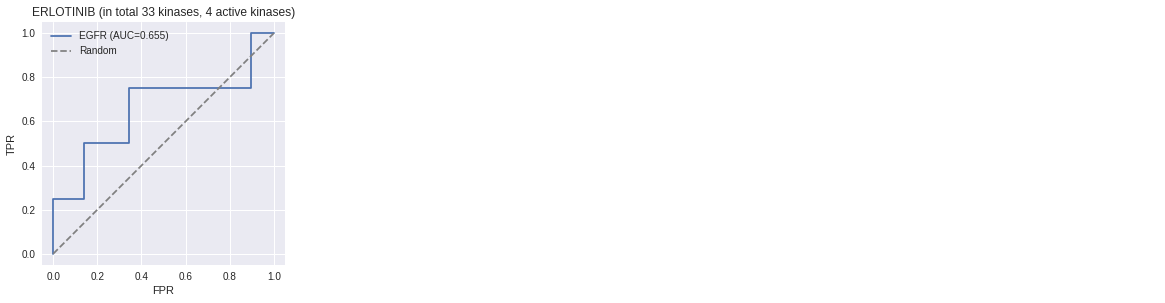

In [10]:
evaluator.plot_roc_curves()

### Fingerprint distances

In [11]:
fingerprint_distances_path = "../../results/fingerprint_distances.csv"
fingerprint_distances = FingerprintDistanceGenerator.from_csv(fingerprint_distances_path)

## Inspect results

### Highly active kinases > on/off-targets

In [12]:
KINASE_ACTIVITY_CUTOFF_STRICT = 30

In [13]:
ligand_kinase_data_active = ligand_kinase_data[
    ligand_kinase_data[f"{LIGAND_PROFILING_METHOD}.measure"] < KINASE_ACTIVITY_CUTOFF_STRICT
]
ligand_kinase_data_active

,karaman.measure,karaman.active,karaman.rank1,karaman.rank2,kissim.measure,kissim.rank1,kissim.rank2
kinase,,,,,,,
EGFR,0.67,True,1.0,1.0,0.000000,1.0,1.0
GAK,3.10,True,2.0,2.0,0.241922,235.0,30.0
LOK,19.00,True,3.0,3.0,0.144295,13.0,6.0
SLK,26.00,True,4.0,4.0,0.159060,39.0,13.0


In [14]:
on_target = ligand_kinase_data_active.index[0]
off_targets = ligand_kinase_data_active.index[1:].to_list()
print(f"Selected on-target: {on_target}")
print(f"Selected off-targets: {off_targets}")

Selected on-target: EGFR
Selected off-targets: ['GAK', 'LOK', 'SLK']


### Bioactivities vs. `kissim` performance

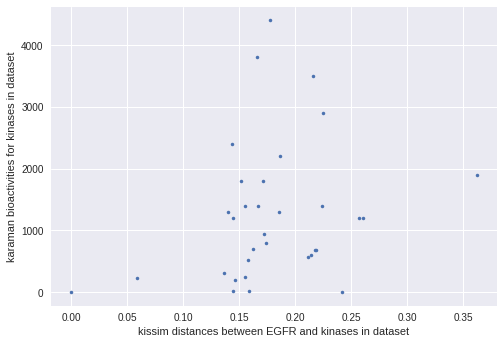

In [15]:
kinase_distances = ligand_kinase_data[f"{KINASE_DISTANCES_METHOD}.measure"]
ligand_profiling = ligand_kinase_data[f"{LIGAND_PROFILING_METHOD}.measure"]


_, ax = plt.subplots(1, 1)
ax.plot(kinase_distances, ligand_profiling, ".")
ax.set_xlabel(f"{KINASE_DISTANCES_METHOD} distances between EGFR and kinases in dataset")
ax.set_ylabel(f"{LIGAND_PROFILING_METHOD} bioactivities for kinases in dataset");

### Easy targets in profiling dataset?

- Are detected off-targets co-crystallized with query ligand?
- Are detected off-targets anyways very close?

In [16]:
off_kinases_structures = []

for off_target in off_targets:
    kinase_dist_df = fingerprint_distances.kinase_distances()
    kinase_dist_df = kinase_dist_df.reset_index()
    kinase_dist_df = kinase_dist_df[
        ((kinase_dist_df["kinase.1"] == on_target) & (kinase_dist_df["kinase.2"] == off_target))
        | ((kinase_dist_df["kinase.1"] == off_target) & (kinase_dist_df["kinase.2"] == on_target))
    ]

    # Structure 1
    structure_klifs_id = kinase_dist_df["structure.1"].to_list()
    ligand = klifs_session.structures.by_structure_klifs_id(structure_klifs_id)[
        "ligand.expo_id"
    ].to_list()
    kinase_dist_df["structure.1.ligand.expo_id"] = ligand
    # Structure 2
    structure_klifs_id = kinase_dist_df["structure.2"].to_list()
    ligand = klifs_session.structures.by_structure_klifs_id(structure_klifs_id)[
        "ligand.expo_id"
    ].to_list()
    kinase_dist_df["structure.2.ligand.expo_id"] = ligand

    # Kinase 1
    kinase_name = kinase_dist_df["kinase.1"].to_list()
    kinase = klifs_session.kinases.by_kinase_name(kinase_name, species="Human")
    kinase_dist_df["kinase.1.group"] = kinase["kinase.group"].to_list()[0]
    kinase_dist_df["kinase.1.family"] = kinase["kinase.family"].to_list()[0]
    # Kinase 2
    kinase_name = kinase_dist_df["kinase.2"].to_list()
    kinase = klifs_session.kinases.by_kinase_name(kinase_name, species="Human")
    kinase_dist_df["kinase.2.group"] = kinase["kinase.group"].to_list()[0]
    kinase_dist_df["kinase.2.family"] = kinase["kinase.family"].to_list()[0]

    off_kinases_structures.append(kinase_dist_df)

off_kinases_structures = pd.concat(off_kinases_structures)

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
off_kinases_structures

,kinase.1,kinase.2,index,structure.1,structure.2,distance,bit_coverage,structure.1.ligand.expo_id,structure.2.ligand.expo_id,kinase.1.group,kinase.1.family,kinase.2.group,kinase.2.family
20840,EGFR,GAK,7555995,12159,10329,0.241922,0.985333,C6O,IRE,TK,EGFR,Other,NAK
20879,EGFR,LOK,7250938,809,10651,0.144295,0.991333,0WN,R70,TK,EGFR,STE,STE20
20971,EGFR,SLK,7566695,12175,10625,0.159060,0.990667,YY3,GUQ,TK,EGFR,STE,STE20


In [18]:
# Get co-crystallized ligand expo IDs
co_crystallized_ligand_expo_ids = (
    off_kinases_structures[["structure.1.ligand.expo_id", "structure.2.ligand.expo_id"]]
    .unstack()
    .unique()
    .tolist()
)

# Map expo IDs to ligand names
co_crystallized_ligands = []
pkidb = data.ligands.pkidb()
for id_ in co_crystallized_ligand_expo_ids:
    ligand_name = pkidb[pkidb["lig_pdbID"] == id_]["ID"]
    if len(ligand_name) == 0:
        co_crystallized_ligands.append([id_, "unknown"])
    else:
        co_crystallized_ligands.append([id_, ligand_name.iloc[0]])
pd.DataFrame(co_crystallized_ligands, columns=["expo_id", "name in PKIDB"])

,expo_id,name in PKIDB
0,C6O,unknown
1,0WN,unknown
2,YY3,Osimertinib
3,IRE,Gefitinib
4,R70,unknown
5,GUQ,unknown


### Difficult targets in profiling dataset?

- Do type II ligands perform worse than type I ligands (because there is less structural information available for type II)?
- Does low kinase coverage lead to worse performance?

#### Do type II ligands perform worse than type I ligands?

In [19]:
pkidb = data.ligands.pkidb()
pkidb.set_index("ID")["Type"][list(evaluator.data_dict.keys())]

ID
Erlotinib    1.5
Name: Type, dtype: object

#### Does low kinase coverage lead to worse performance?

In [20]:
# Kinase pairs coverages
kinase_matrix_size = fingerprint_distances.kinase_distance_matrix(by="size")
kinase_matrix_size = kinase_matrix_size.loc[on_target, off_targets]
# Kinase pair distances
kinase_matrix_min = fingerprint_distances.kinase_distance_matrix()
kinase_matrix_min = kinase_matrix_min.loc[on_target, off_targets]
# Merge data
kinase_coverage = pd.concat([kinase_matrix_size, kinase_matrix_min], axis=1)
kinase_coverage.columns = ["coverage", "distance"]
kinase_coverage.index.name = f"{on_target} to"
kinase_coverage

,coverage,distance
EGFR to,,
GAK,1274,0.241922
LOK,2184,0.144295
SLK,1092,0.159060
